# Random Forest Model to Predict Need for Rehabilitation

In [7]:
import pandas as pd
import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

df = spark.sql("SELECT * FROM PT_evals_lakehouse.pt_eval_generated LIMIT 1000")
df = df.toPandas()

del df['tx_need_rehab']
del df['tx_prior_loc']
del df['Prior_location']

experiment_name = "experiment-pt-need-for-rehab"
mlflow.set_experiment(experiment_name)

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 9, Finished, Available, Finished)

<Experiment: artifact_location='', creation_time=1723134646679, experiment_id='c75cf239-8e7d-4523-abcb-9b0e7ded18d0', last_update_time=None, lifecycle_stage='active', name='experiment-pt-need-for-rehab', tags={}>

In [8]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, expr
 
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("sex", StringType(), True),
    StructField("fusion", StringType(), True),
    StructField("provider", StringType(), True),
    StructField("brace", StringType(), True),
    StructField("pain", StringType(), True),
    StructField("prior_loc", IntegerType(), True),
    StructField("ste", IntegerType(), True),
    StructField("hr", IntegerType(), True),
    StructField("ad", IntegerType(), True),
    StructField("num_falls", IntegerType(), True),
    StructField("sup_sit", IntegerType(), True),
    StructField("sit_stand", IntegerType(), True),
    StructField("amb_assist", IntegerType(), True),
    StructField("amb_distance", IntegerType(), True),
    StructField("stairs_assist", IntegerType(), True),
    StructField("num_stairs", IntegerType(), True),
    StructField("los", DoubleType(), True),
    StructField("dc_loc", IntegerType(), True),
    StructField("need_rehab", IntegerType(), True)
])

rows = [Row(**row) for row in df.to_dict(orient='records')]

# Create the Spark DataFrame
spark_df = spark.createDataFrame(rows, schema=schema)

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 10, Finished, Available, Finished)

In [9]:
cat_features = ['sex', 'fusion', 'brace', 'provider', 'ad', 'prior_loc', 'pain', 'sup_sit', 'sit_stand', 'amb_assist', 'stairs_assist']
num_features = [col for col in spark_df.columns[:-3] if col not in cat_features]

ix_features = [c + '_ix' for c in cat_features]
 
label_indexer = StringIndexer(inputCol='need_rehab', outputCol='label')
 
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)
 
assembler = VectorAssembler(inputCols=num_features + ix_features, outputCol='features')

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 11, Finished, Available, Finished)

In [10]:
pipeline = Pipeline(stages=[label_indexer, feature_indexer, assembler]).fit(spark_df)
spark_df_pipelined = pipeline.transform(spark_df)

train, test = spark_df_pipelined.randomSplit([0.8, 0.2], seed=1)

accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 12, Finished, Available, Finished)

2024-08-08:16:49:36,520 WARNING  [tracking_store.py:153] log_inputs not supported


In [11]:
rforest = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20, seed=1)
 
param_grid = (ParamGridBuilder()
              .addGrid(rforest.maxDepth, range(2, 18, 2) )
              .addGrid(rforest.minInstancesPerNode, [4, 8, 16, 32])
              ).build()
 
cv = CrossValidator(estimator=rforest, estimatorParamMaps=param_grid, numFolds=10, 
                    evaluator=accuracy_eval, seed=1, parallelism=6)
 
cv_model = cv.fit(train)

opt_rf_model = cv_model.bestModel
opt_maxDepth = opt_rf_model.getMaxDepth()
opt_minInstancesPerNode = opt_rf_model.getMinInstancesPerNode()

# mlflow.sklearn.log_model(opt_rf_model, "random forest model", signature = signature)

print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', opt_maxDepth)
print('Optimal MinInst:', opt_minInstancesPerNode)

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 13, Finished, Available, Finished)

2024-08-08:16:50:03,482 WARNING  [tracking_store.py:153] log_inputs not supported


Max CV Score:   0.8288
Optimal Depth:   6
Optimal MinInst: 8


StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 14, Finished, Available, Finished)

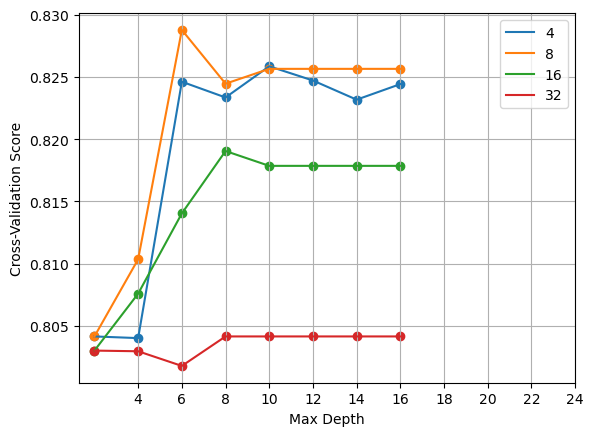

In [12]:
import matplotlib.pyplot as plt
def graph_params(model): 
    model_params = model.getEstimatorParamMaps()
    dt_cv_summary_list = []
    for param_set, acc in zip(model_params, model.avgMetrics):
        new_set = list(param_set.values()) + [acc]
        dt_cv_summary_list.append(new_set)
    cv_summary = pd.DataFrame(dt_cv_summary_list,
                                columns=['maxDepth', 'minInst', 'acc'])
    for mi in cv_summary.minInst.unique():
        sel = cv_summary.minInst == mi
        plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
        plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])
    plt.legend()
    plt.grid()
    plt.xticks(range(4,26,2))
    plt.xlabel('Max Depth')
    plt.ylabel('Cross-Validation Score')
    plt.show()

graph_params(cv_model)

In [13]:
from pyspark.mllib.evaluation import MulticlassMetrics
def count_proportions(test_predictions):
    N = test_predictions.count()
    df = test_predictions.select('need_rehab').groupBy('need_rehab').agg(
        expr('count(*) as count'), 
        expr(f'round(count(*)/{N},2) as prop')
    ).show()
    
    return df
def model_accuracy(model, test_set):
    test_pred = model.transform(test_set)
    pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['label'])))
    metrics = MulticlassMetrics(pred_and_labels)
    
    return metrics.accuracy

def model_cm(model, test_set):
    test_pred = model.transform(test_set)
    pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['label'])))
    metrics = MulticlassMetrics(pred_and_labels)
    cm = metrics.confusionMatrix().toArray().astype(int)
    labels = range(0,2)
    matrix = pd.DataFrame(
        data=cm, 
        columns=labels,
        index=labels
    )
    return matrix


print(count_proportions(opt_rf_model.transform(test)))

print(f'Model Accuracy: {model_accuracy(opt_rf_model, test)}')
print(model_cm(opt_rf_model, test))

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 15, Finished, Available, Finished)

+----------+-----+----+
|need_rehab|count|prop|
+----------+-----+----+
|         1|  110|0.52|
|         0|  101|0.48|
+----------+-----+----+

None
Model Accuracy: 0.8151658767772512
    0   1
0  94  16
1  23  78


/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [14]:
def importances(numerical_ft, categorical_ft, model):
    ft = numerical_ft+categorical_ft
    importance = pd.DataFrame({
        'features' : ft
    })
    importance['importance'] = 0.0
    lst = list(model.featureImportances)
    
    for index, value in enumerate(lst):
        importance.loc[index,'importance'] = value
    return importance

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 16, Finished, Available, Finished)

In [15]:
importances(num_features, cat_features, opt_rf_model).sort_values('importance', ascending = False)

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 17, Finished, Available, Finished)

,features,importance
4,amb_distance,0.495262
11,prior_loc,0.176761
7,fusion,0.054348
3,num_falls,0.037643
16,stairs_assist,0.033342
14,sit_stand,0.031838
8,brace,0.028213
0,age,0.025492
12,pain,0.021696
15,amb_assist,0.020840


It is important to remember that much of the data is completely random and almost nonsensical currently. We can predict that this will reduce importances of items we did not include in our assumptions when producing the random data. We can, however, see that ambulation distance as well as prior level of function have significant importances greater than the other features.

Let's reduce the number of features to see if we can create a stronger model.

In [16]:
spark_df_reduced = spark_df.select('num_falls', 'amb_distance', 'fusion', 'prior_loc', 'pain', 'need_rehab')

cat_features_reduced = ['fusion', 'prior_loc', 'pain']
num_features_reduced = ['num_falls', 'amb_distance']

ix_features_reduced = [c + '_ix' for c in cat_features_reduced]
 
label_indexer = StringIndexer(inputCol='need_rehab', outputCol='label')
 
feature_indexer = StringIndexer(inputCols=cat_features_reduced, outputCols=ix_features_reduced)
 
assembler = VectorAssembler(inputCols=num_features_reduced + ix_features_reduced, outputCol='features')



StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 18, Finished, Available, Finished)

In [17]:
pipeline = Pipeline(stages=[label_indexer, feature_indexer, assembler]).fit(spark_df_reduced)
spark_df_pipeline_reduced = pipeline.transform(spark_df_reduced)

train_reduced, test_reduced = spark_df_pipeline_reduced.randomSplit([0.8, 0.2], seed=1)

accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

rforest = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20, seed=1)
 
param_grid = (ParamGridBuilder()
              .addGrid(rforest.maxDepth, range(2, 18, 2) )
              .addGrid(rforest.minInstancesPerNode, [4, 8, 16, 32])
              ).build()
 
cv_reduced = CrossValidator(estimator=rforest, estimatorParamMaps=param_grid, numFolds=10, 
                    evaluator=accuracy_eval, seed=1, parallelism=6)
 
cv_model_reduced = cv_reduced.fit(train_reduced)
 
opt_rf_model_reduced = cv_model_reduced.bestModel
opt_maxDepth_reduced = opt_rf_model_reduced.getMaxDepth()
opt_minInstancesPerNode_reduced = opt_rf_model_reduced.getMinInstancesPerNode()

print('Max CV Score:  ', round(max(cv_model_reduced.avgMetrics),4))
print('Optimal Depth:  ', opt_maxDepth_reduced)
print('Optimal MinInst:', opt_minInstancesPerNode_reduced)

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 19, Finished, Available, Finished)

2024-08-08:16:54:35,613 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-08:16:54:51,897 WARNING  [tracking_store.py:153] log_inputs not supported


Max CV Score:   0.8324
Optimal Depth:   4
Optimal MinInst: 8


StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 20, Finished, Available, Finished)

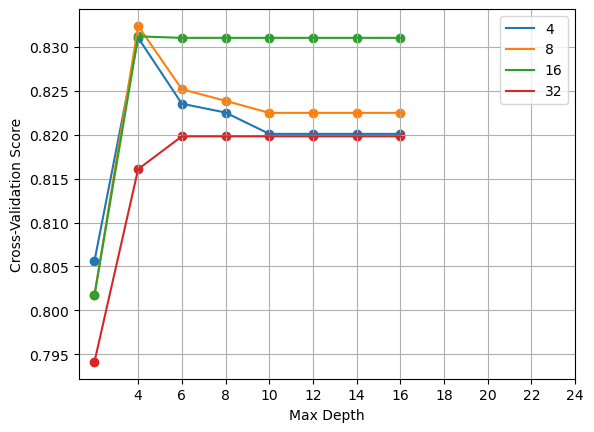

In [18]:
graph_params(cv_model_reduced)

In [19]:
print(count_proportions(opt_rf_model_reduced.transform(test_reduced)))
print(f'Model Accuracy: {model_accuracy(opt_rf_model_reduced, test_reduced)}')
print(model_cm(opt_rf_model_reduced, test_reduced))

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 21, Finished, Available, Finished)

+----------+-----+----+
|need_rehab|count|prop|
+----------+-----+----+
|         1|  112|0.53|
|         0|   99|0.47|
+----------+-----+----+

None
Model Accuracy: 0.8483412322274881
     0   1
0  101  11
1   21  78


/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [20]:
importances(num_features_reduced, cat_features_reduced, opt_rf_model_reduced).sort_values('importance', ascending= False)

StatementMeta(, f8972434-73df-4ded-b1a2-609fbbc233f6, 22, Finished, Available, Finished)

,features,importance
1,amb_distance,0.647757
3,prior_loc,0.251046
4,pain,0.037036
2,fusion,0.033819
0,num_falls,0.030342
